In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fasttext
import requests
import skimage
import shutil
import torch
import json
import cv2

from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm.auto import trange, tqdm
from torchvision import datasets, models, transforms

# Helper for downloading models from google drive

In [2]:
import requests

def download_file_from_google_drive(_id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : _id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : _id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

# Load test data

In [5]:
import re

def normalize_text(t):
    without_tags = re.sub(r"<.*?>|\[.*?\]|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|\t|\n", " ", t)
    word_list = without_tags.strip().lower().split()
    without_stop_words = " ".join(word_list)
    return without_stop_words

Path("./test_dataset").mkdir(parents=True, exist_ok=True)

def download_image(url):
    response = requests.get(url)
    file_path = f"./test_dataset/{url.split('/')[-1]}"
    img_bytes = np.frombuffer(response.content, np.uint8)
    cv2.imwrite(file_path, cv2.imdecode(img_bytes, cv2.IMREAD_COLOR))
    return file_path

In [4]:
test_categories = pd.read_csv("https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_categories.txt", header=None, index_col=None)[0]
test_products_df = pd.read_json("https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_data.json")

test_categories = test_categories.apply(normalize_text)
test_products_df["description"] = test_products_df["description"].apply(normalize_text)
test_products_df["img_path"] = test_products_df.image_url.apply(download_image)

test_products_df.drop_duplicates("img_path", inplace=True)

# Load models

In [6]:
PRETRAINED_LABEL_TO_ID = {
    'accessories': 0, 'apparel set': 1, 'bags': 2, 'bath and body': 3, 'beauty accessories': 4, 'belts': 5, 'bottomwear': 6, 'cufflinks': 7,
    'dress': 8, 'eyes': 9, 'eyewear': 10, 'flip flops': 11, 'fragrance': 12, 'free gifts': 13, 'gloves': 14, 'hair': 15, 'headwear': 16, 'home furnishing': 17,
    'innerwear': 18, 'jewellery': 19, 'lips': 20, 'loungewear and nightwear': 21, 'makeup': 22, 'mufflers': 23, 'nails': 24, 'perfumes': 25, 'sandal': 26,
    'saree': 27, 'scarves': 28, 'shoe accessories': 29, 'shoes': 30, 'skin': 31, 'skin care': 32, 'socks': 33, 'sports accessories': 34, 'sports equipment': 35,
    'stoles': 36, 'ties': 37, 'topwear': 38, 'umbrellas': 39, 'vouchers': 40, 'wallets': 41, 'watches': 42, 'water bottle': 43, 'wristbands': 44}
ID_TO_PRETRAINED_LABEL = {v: k for k, v in PRETRAINED_LABEL_TO_ID.items()}

## Image model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_model = models.mobilenet_v2().to(device)
image_model.classifier[-1] = torch.nn.Linear(1280, len(PRETRAINED_LABEL_TO_ID)).to(device)

In [8]:
_file_id = "1Fe_DTre1Fr3osRDVGSR0zAzrtTJGkfHa"
_model_destination = "trained_models/image_categorization.pt"
download_file_from_google_drive(_file_id, _model_destination)

image_model.load_state_dict(torch.load(_model_destination))
image_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

## Load text model (it's big, this may take some time)

In [9]:
_file_id = "1_Dbk5KPuVaCf8KD6DICzhA_QcSvxS8Lj"
_model_destination = "trained_models/text_categorization.bin"
download_file_from_google_drive(_file_id, _model_destination)

text_model = fasttext.load_model(_model_destination)

# Inference on the test set

In [10]:
TOP_K_PREDICTIONS = 3

The test set has a different set of labels from what the models were trained, so, in order to infer the categories of products on the test set, we're going to **project** the test labels on the same label space the models were trained.
<br>After projecting the test labels, we're going to use the averaged pre-trained models predictions and compute **the nearest neighbors with KL-divergence** from the test labels.
<br><br>It goes as follows:

## I) Test set inferences, on their own "labels space"

### Images first

In [11]:
from pathlib import Path
from PIL import Image

p = Path("test_dataset/")

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform):
        self.image_paths = list(Path(image_path).glob('*.jpg'))
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [84]:
test_img_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [85]:
image_model.eval()
image_model_predictions = []

for img_path in tqdm(test_products_df["img_path"]):
    inputs = test_img_transforms(Image.open(img_path)).to(device).unsqueeze(0)
    with torch.no_grad():
        outputs = torch.nn.Softmax(-1)(image_model(inputs))
    image_model_predictions.extend(outputs.cpu().numpy())
image_model_predictions = np.array(image_model_predictions)

  0%|          | 0/992 [00:00<?, ?it/s]

### Text inferences

In [86]:
text_model_predictions = [
    text_model.predict(description, k=3) 
    for description in test_products_df["description"]
]

## Ensemble both inferences with an average of the predictions

In [87]:
def get_img_one_hot_prediction(img_prediction):
    top_img_probabilities = np.zeros(len(text_model.get_labels()))
    top_img_preds = np.argpartition(img_prediction, -TOP_K_PREDICTIONS)[-TOP_K_PREDICTIONS:]
    top_img_preds_probabilities = img_prediction[top_img_preds] / img_prediction[top_img_preds].sum()
    top_img_probabilities[top_img_preds] = top_img_preds_probabilities
    return top_img_probabilities


def get_txt_one_hot_prediction(txt_prediction):
    top_txt_probabilities = np.zeros(len(text_model.get_labels()))
    top_txt_preds = list(map(lambda label: int(label.split("__")[-1]), txt_prediction[0]))
    top_txt_preds_probabilities = txt_prediction[1]/txt_prediction[1].sum()
    top_txt_probabilities[top_txt_preds] = top_txt_preds_probabilities
    return top_txt_probabilities

In [88]:
ensembled_preds = []
for (img_prediction, txt_prediction) in zip(image_model_predictions, text_model_predictions):
    
    # Get top k image predictions
    top_img_probabilities = get_img_one_hot_prediction(img_prediction)

    # Get top k text predictions
    top_txt_probabilities = get_txt_one_hot_prediction(txt_prediction)
    
    # Merge both predictions by summing up probabilities on the same class
    _ensembled_probabilities = top_txt_probabilities + top_img_probabilities
    _ensembled_probabilities /= _ensembled_probabilities.sum()

    ensembled_preds.append(_ensembled_probabilities)

## Assign the test class with lowest KL-divergence

We'll project the test labels into the train labels distribution and then, with this new test label representation, we'll compute the **KL-Divergence** (it computes "distances" between probability distributions) between each test label and the predicted probabilities. <br>The final inference will be that which holds the smallest the KL-divergence.

In [89]:
def kl_divergence(p, q):
    EPS = 1e-8
    p = np.asarray(p)
    q = np.asarray(q)

    return np.sum(np.where(p != 0, p * np.log((p+EPS) / (q+EPS)), 0))

In [90]:
test_labels_probabilities = [
    get_txt_one_hot_prediction(text_model.predict(label, k=3) )
    for label in test_categories
]

In [91]:
test_predictions = []
for idx, ensembled_prediction in enumerate(ensembled_preds):
    nearest_label = np.argmin([
        kl_divergence(ensembled_prediction, test_label_probabilities) 
        for test_label_probabilities in test_labels_probabilities
    ])
    test_predictions.append(ID_TO_PRETRAINED_LABEL[nearest_label])

test_products_df["inferred_category"] = test_predictions

# Visual inspection of results and conclusions

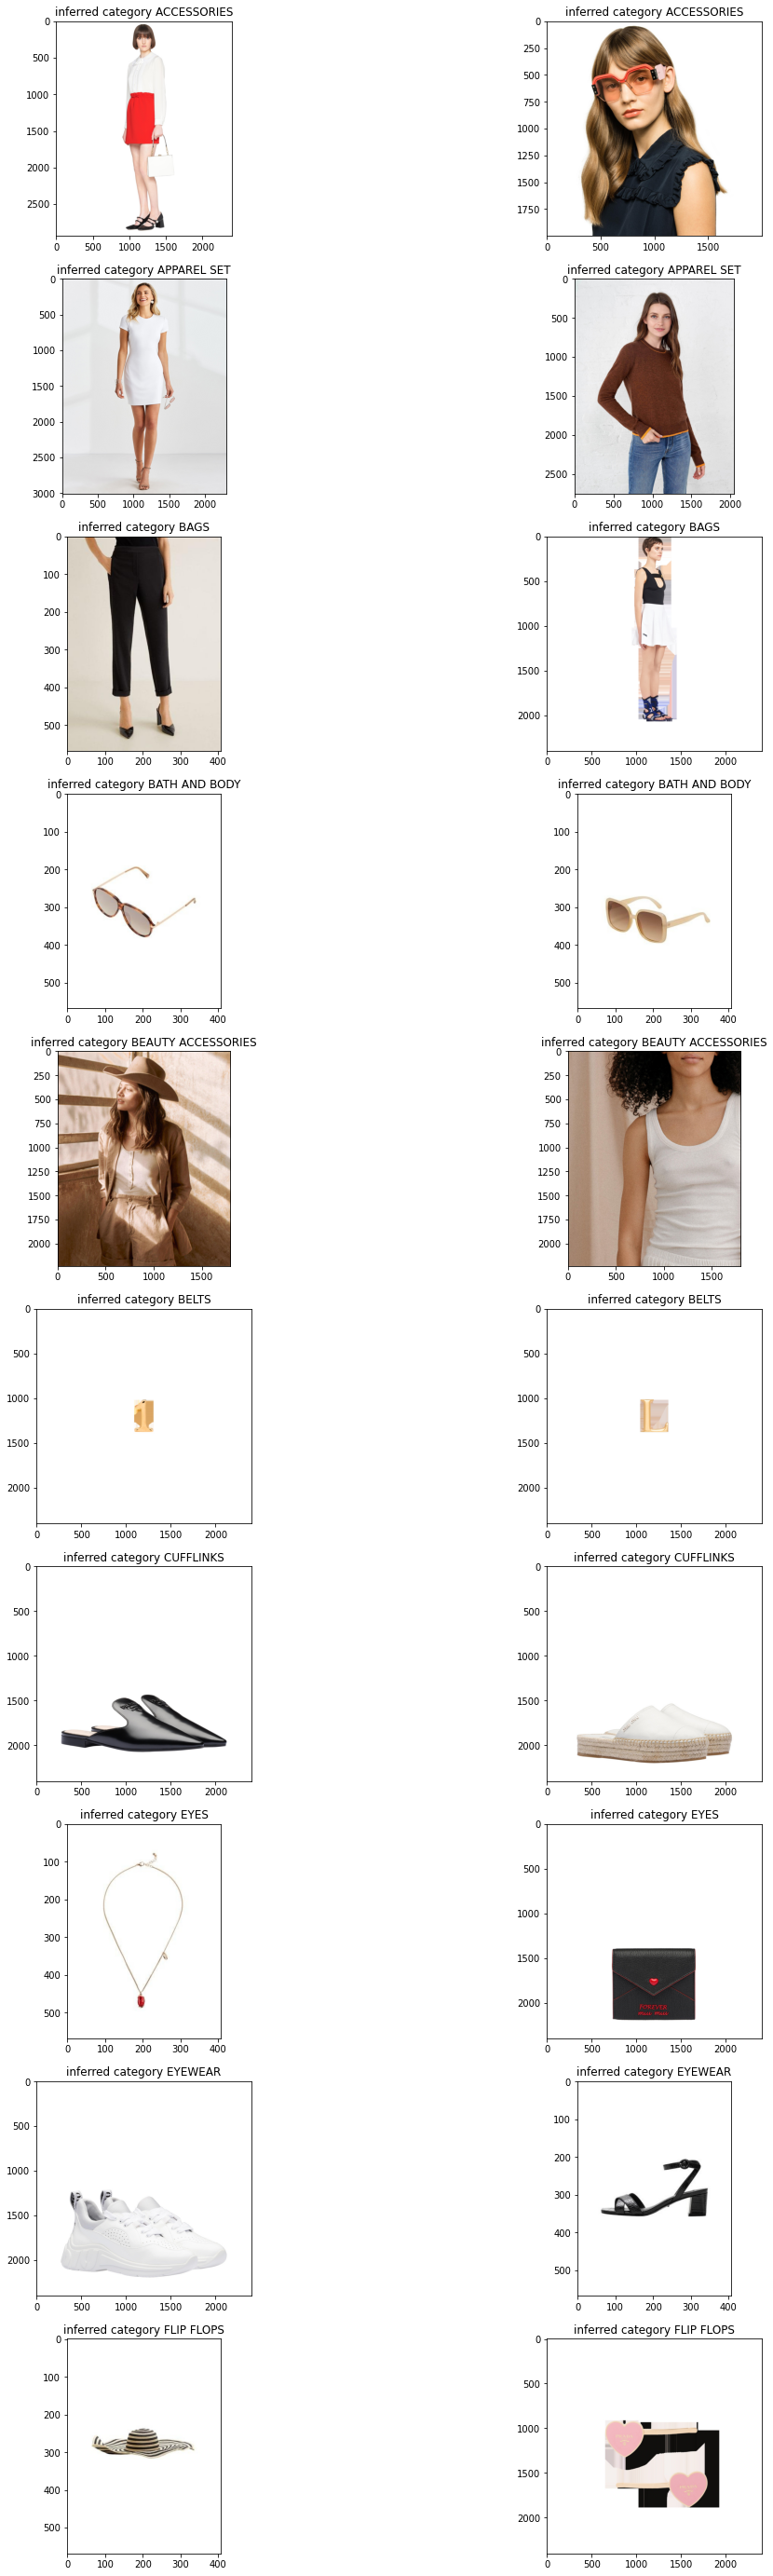

In [83]:
import matplotlib.image as mpimg

f, axes = plt.subplots(10, 2, figsize=(18, 50))
for idx, (_, product) in enumerate(test_products_df.groupby("inferred_category").sample(2).iterrows()):
    current_axis = axes[idx//2][0 if idx%2==0 else 1]
    img = mpimg.imread(product["img_path"])
    current_axis.imshow(img) 
    current_axis.set_title(f'inferred category {product["inferred_category"].upper()}')

Well, it didn't perform as good as one would expect. And that is due to fact that models weren't properly evaluated and tuned on the target distribution, but only on the dummy train dataset.
<br>
With more time, I would:
- Try to better fit and evaluate both models indivudually, checking the error cases on the desired final dataset.
- Find a more representative dataset for the first training phase.